# Exploring raw Bu2023Ye dataset

**Abstract** This is a notebook where I play around with the data of the Bu2023Ye model, without having performed the preprocessing steps and using directly the HDF5 files. 

In [1]:
%load_ext autoreload 
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import h5py
import tqdm
import inspect 

# NMMA imports
import nmma
from nmma.em.io import read_photometry_files
from nmma.em.utils import interpolate_nans
from nmma.em.training import SVDTrainingModel
import nmma.em.model_parameters as model_parameters

# tensorflow imports
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16
        }

plt.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Install wrapt_timeout_decorator if you want timeout simulations.


2024-01-03 16:37:05.369849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-03 16:37:05.479984: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-03 16:37:06.067428: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: ~/MultiNest/lib/
2024-01-03 16:37:06.067509: W tensorflow/compiler/xla/stream_executor/

## Loading and exploring the dataset

### Exploring dataset on my own

In [2]:
def get_time(filename):
    """
    This is to read in the lightcurve data from the file. Note: this is specifically for the Bu2023Ye dataset.
    """
    with h5py.File(filename, 'r') as f:
        time =  f['observables']['time'][()]
    return time

def get_lbol(filename):
    """
    This is to read in the lightcurve data from the file. Note: this is specifically for the Bu2023Ye dataset.
    """
    
    with h5py.File(filename, 'r') as f:
        ### These are all the observables:
        # model = f['model']
        # observables = f['observables']
        # ye, density, energy, temperature, velocity = model['Ye'][()], model['density'][()], model['energy'][()], model['temperature'][()], model['velocity'][()]
        # lbol, stokes, stokes_map, time, vel_map, wave = observables['lbol'][()], observables['stokes'][()], observables['stokes_map'][()], observables['time'][()], observables['vel_map'][()], observables['wave'][()]
        
        ### Now limit to time and lbol
        lbol =  f['observables']['lbol'][()]
        
    return lbol

NOTE: reading only lbol and time is much faster than all the entries that are unused anyway...

For only those 2, reading all LC files takes around 40 seconds here.

In [61]:
lcs_dir = "/home/enlil/markin/public_html/data/possis_chemical/possis_chemical_all"
model_name = "Bu2023Ye"
jump_size = 1 # jump over files to speed up the process

filenames = os.listdir(lcs_dir)
filenames = [f for f in filenames if f.endswith(".hdf5")]
print(filenames)
full_filenames = [os.path.join(lcs_dir, f) for f in filenames]
print(f"There are {len(full_filenames)} lightcurves for this model.")
full_filenames = full_filenames[::jump_size]
print(f"We now check {len(full_filenames)} lightcurves for exploring data.")

# Fetch the time: we checked that it is the same across all lightcurve files
time = get_time(full_filenames[0])

# Fetch the lbol data:

## Read in the lightcurve data as example
print("Reading in lightcurve data...")
data_dict = {}
for filename in tqdm.tqdm(full_filenames):
    lbol = get_lbol(filename)
    data_dict[filename] = lbol
print("Reading in lightcurve data... DONE!")

['MDyn0.001_vDyn0.20_YeDyn0.20_MWind0.010_vWind0.05_YeWind0.2.hdf5', 'MDyn0.020_vDyn0.15_YeDyn0.25_MWind0.130_vWind0.05_YeWind0.2.hdf5', 'MDyn0.020_vDyn0.20_YeDyn0.20_MWind0.090_vWind0.05_YeWind0.2.hdf5', 'MDyn0.005_vDyn0.15_YeDyn0.25_MWind0.050_vWind0.15_YeWind0.2.hdf5', 'MDyn0.005_vDyn0.25_YeDyn0.15_MWind0.010_vWind0.15_YeWind0.2.hdf5', 'MDyn0.010_vDyn0.25_YeDyn0.30_MWind0.090_vWind0.03_YeWind0.2.hdf5', 'dyn0.010-0.12-0.25_wind0.090-0.10_YeWind0.3.hdf5', 'MDyn0.005_vDyn0.12_YeDyn0.15_MWind0.090_vWind0.05_YeWind0.4.hdf5', 'dyn0.005-0.15-0.15_wind0.130-0.05_YeWind0.3.hdf5', 'dyn0.010-0.25-0.25_wind0.050-0.15_YeWind0.3.hdf5', 'dyn0.020-0.15-0.20_wind0.090-0.10_YeWind0.3.hdf5', 'MDyn0.005_vDyn0.20_YeDyn0.15_MWind0.090_vWind0.15_YeWind0.2.hdf5', 'MDyn0.005_vDyn0.20_YeDyn0.20_MWind0.130_vWind0.15_YeWind0.4.hdf5', 'MDyn0.005_vDyn0.15_YeDyn0.20_MWind0.130_vWind0.05_YeWind0.2.hdf5', 'MDyn0.020_vDyn0.15_YeDyn0.20_MWind0.050_vWind0.05_YeWind0.2.hdf5', 'MDyn0.005_vDyn0.12_YeDyn0.15_MWind0.130_vW

100%|██████████| 3072/3072 [00:08<00:00, 360.12it/s]

Reading in lightcurve data... DONE!


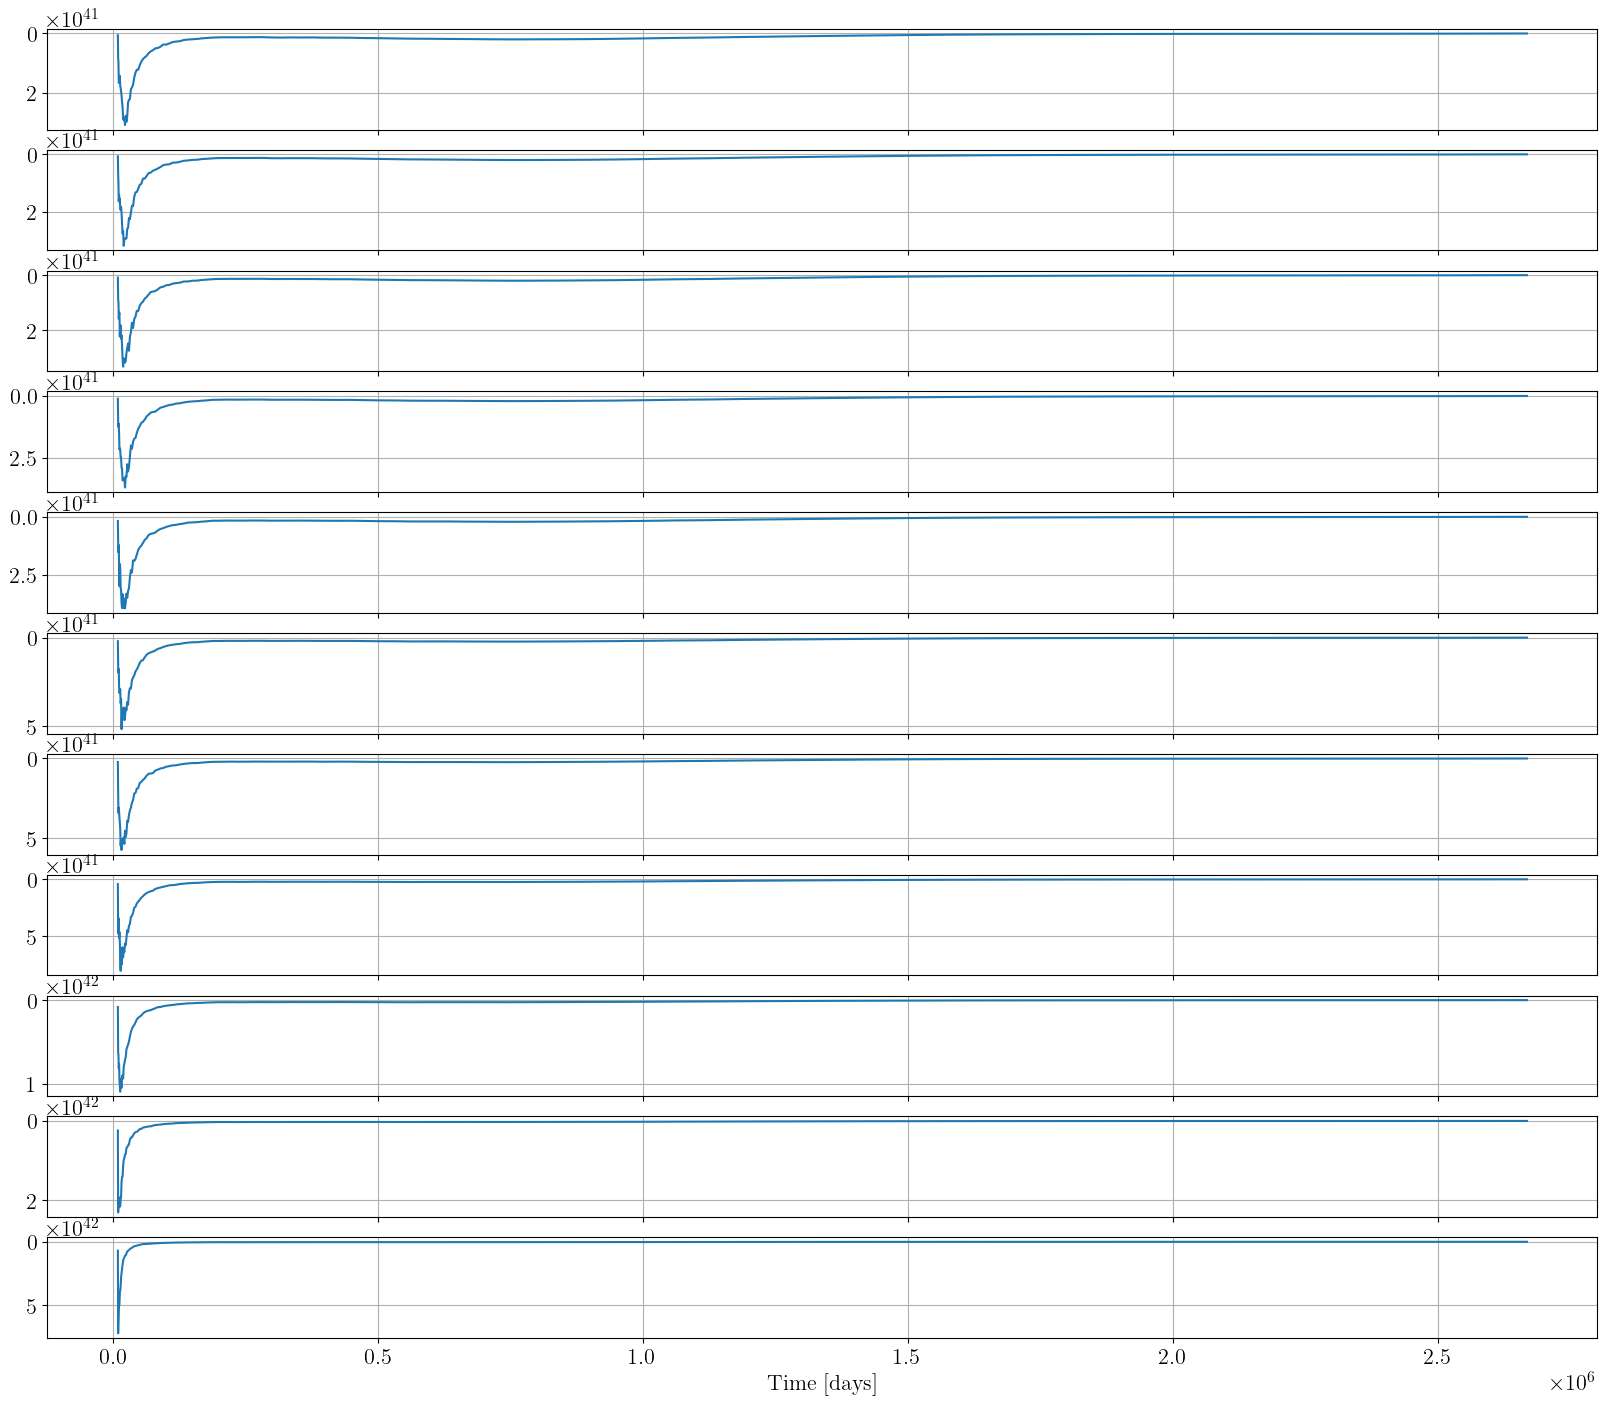

In [58]:
first_name = full_filenames[0]
example_lc = data_dict[first_name]
nrow = len(example_lc)

fig, axs = plt.subplots(nrow, 1, figsize=(20, 17), sharex = True)
for i, value in enumerate(example_lc):
    plt.subplot(nrow, 1, i+1)
    plt.plot(time, value)
    axs[i].invert_yaxis()
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Time [days]")
plt.show()

In [76]:
# import re

# test_string = filenames[-1]
# test_string = 'dyn0.005-0.15-0.15_wind0.130-0.05_YeWind0.3.hdf5'

# print(test_string)

# for jj, key in enumerate(test_string):
#     rr = [
#         np.abs(float(x))
#         for x in re.findall(
#             r"[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", key
#         )
#     ]
# print(rr)

dyn0.005-0.15-0.15_wind0.130-0.05_YeWind0.3.hdf5
[5.0]


### Reading in with NMMA io

In [67]:
data = read_photometry_files(full_filenames, datatype="hdf5")

ValueError: Cannot convert a table with multidimensional columns to a pandas DataFrame. Offending columns are: ['Ye', 'density', 'temperature']
One can filter out such columns using:
names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
tbl[names].to_pandas(...)

NOTE - not sure how to do this now, we are not having photometry files in the correct format?

In [59]:
# data = read_photometry_files(full_filenames)
# data = interpolate_nans(data)

# keys = list(data.keys())
# filts = sorted(list(set(data[keys[0]].keys()) - {"t"}))
# print(filts)

Extract the parameters

In [64]:
MODEL_FUNCTIONS = {
    k: v for k, v in model_parameters.__dict__.items() if inspect.isfunction(v)
}
MODEL_FUNCTIONS

model_function = MODEL_FUNCTIONS[model_name]

In [65]:
extracted_model = {}

for filename in tqdm.tqdm(full_filenames):
    extracted_model[filename] = model_function(filename)

  0%|          | 0/3072 [00:00<?, ?it/s]


AttributeError: 'str' object has no attribute 'keys'

# ==== todo ====

## Process training data

In [ ]:
# # Apply it to our dataset:
# training_data, parameters = model_function(data)

In [ ]:
# example_key = list(training_data.keys())[0]
# example_training_data = training_data[example_key]
# print(f"Keys (and some values) of dictionary of {example_key}")
# for key in example_training_data.keys():
#     value = example_training_data[key]
#     if key in parameters:
#         print(f"{key} : {value}")
#     else:
#         print(key)

In [ ]:
# svd_ncoeff = 10 # NOTE this has to be tuned?
# training_model = SVDTrainingModel(
#         model_name,
#         training_data,
#         parameters,
#         t,
#         filts,
#         n_coeff=svd_ncoeff,
#         interpolation_type="tensorflow",
#         start_training=False # don't train, just prep the data
# )

In [ ]:
# svd_model = training_model.generate_svd_model()
# training_model.svd_model = svd_model

## Training

In [ ]:
# first_filter = filts[0]

# X = training_model.svd_model[first_filter]['param_array_postprocess'] # complete dataset of input data of network
# n_samples, input_ndim = X.shape
# print(f"Features (input) have shape {X.shape}")

# y = training_model.svd_model[first_filter]['cAmat'].T
# _, output_ndim = y.shape
# print(f"Labels (output) have shape {y.shape}")